In [1]:
import numpy as np
import ROOT

c1 = ROOT.TCanvas()

Welcome to JupyROOT 6.24/00


In [2]:
rootfile = ROOT.TFile.Open("data/HiggsZZ4mu.root")
roottree = rootfile.Get("Events")

In [3]:
h2 = ROOT.TH1D("h2", "mass", 120, 0, 120)

for index, event in enumerate(roottree):
    # Applying cuts means if-statements.
    if event.nMuon >= 2 and event.Muon_charge[0] + event.Muon_charge[1] == 0:
        mu1_pt = event.Muon_pt[0]
        mu2_pt = event.Muon_pt[1]
        mu1_eta = event.Muon_eta[0]
        mu2_eta = event.Muon_eta[1]
        mu1_phi = event.Muon_phi[0]
        mu2_phi = event.Muon_phi[1]
        h2.Fill(np.sqrt(2*mu1_pt*mu2_pt*(np.cosh(mu1_eta - mu2_eta) - np.cos(mu1_phi - mu2_phi))))

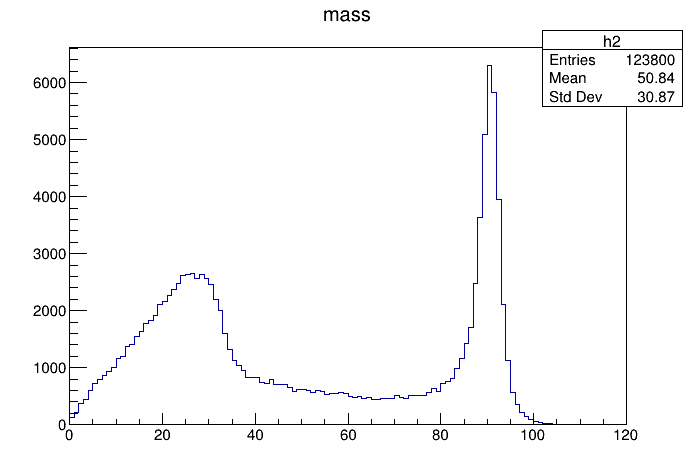

In [4]:
h2.Draw()
c1.Draw()

In [5]:
import awkward as ak
import uproot
import hist

In [6]:
events = uproot.open("data/HiggsZZ4mu.root:Events")
events.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
HLT_IsoMu24_eta2p1   | bool                     | AsDtype('bool')
HLT_IsoMu24          | bool                     | AsDtype('bool')
HLT_IsoMu17_eta2p... | bool                     | AsDtype('bool')
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge          | int32_t[]                | AsJagged(AsDtype('>i4'))


In [7]:
muons = events.arrays(
    ["pt", "eta", "phi", "charge"],
    aliases={"pt": "Muon_pt", "eta": "Muon_eta", "phi": "Muon_phi", "charge": "Muon_charge"}
)

In [8]:
cut = (ak.num(muons.charge) >= 2) & (ak.sum(muons.charge[:, :2], axis=1) == 0)

In [9]:
mu1 = muons[cut, 0]
mu2 = muons[cut, 1]

In [10]:
h1 = hist.Hist.new.Reg(120, 0, 120, name="mass").Double()

In [11]:
h1.fill(np.sqrt(2*mu1.pt*mu2.pt*(np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))))

Hist(Regular(120, 0, 120, name='mass', label='mass'), storage=Double()) # Sum: 123753.0 (123800.0 with flow)

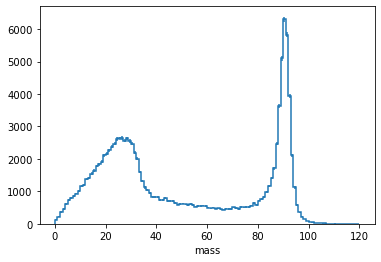

In [12]:
import matplotlib.pyplot as plt

h1.plot();